In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import datetime
import holidays


In [365]:


# Energy data
energy_data_1 = pd.read_csv('../data/raw/energy/20_000100-2023-04-29 09 37 58.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','energy'])
energy_data_2 = pd.read_csv('../data/raw/energy/20_999100-2023-04-29 09 39 26.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','energy'])
# Special loads
lab_251102 = pd.read_csv('../data/raw/special_loads/20_251102.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','power'])
lab_P011 = pd.read_csv('../data/raw/special_loads/P011.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','power'])
lab_P015 = pd.read_csv('../data/raw/special_loads/P015.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','power'])
lab_P051 = pd.read_csv('../data/raw/special_loads/P051.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','power'])



# Weather data
glob_irrad_in_diffuse_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B01_GlobIrradInDiffuse_Disc-2023-04-29 09 40 50.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','glob_irrad_in_diffuse'])
glob_irrad_total_disc_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B01_GlobIrradTotal_Disc-2023-04-29 09 41 36.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','glob_irrad_total_disc'])
sunhine_detect_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B01_SunshineDetect_Disc-2023-04-29 09 42 07.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','sunhine_detect'])
abs_hum_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B02_AbsHum-2023-04-29 09 42 27.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','abs_hum'])
dew_point_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B02_DewPoint-2023-04-29 09 42 52.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','dew_point'])
enth_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B02_Enth-2023-04-29 09 43 13.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','enth'])
rel_hum_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B02_RelHum-2023-04-29 09 43 30.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','rel_hum'])
temp_df = pd.read_csv('../data/raw/weather/IN1IN13DG_WETT_S02_B02_Temp-2023-04-29 09 43 47.csv',
    index_col=0, parse_dates=False, skiprows=1,names=['time','temp'])


In [ ]:
def parse_timestamp(timestamp):
    timestamp = pd.to_datetime(timestamp, unit='ms', utc=False)
    timestamp = timestamp + pd.Timedelta(hours=1) # Convert to TZ Europe/Wien
    
    return timestamp

In [367]:

dataframes = [
    energy_data_1, energy_data_2, lab_P051, lab_P015, lab_P011,
    lab_251102, glob_irrad_in_diffuse_df, glob_irrad_total_disc_df,
    sunhine_detect_df, abs_hum_df, dew_point_df, enth_df,
    rel_hum_df, temp_df
]
for df in dataframes:
    df.index= parse_timestamp(df.index)
    
    

In [ ]:
energy_data_1 = energy_data_1.asfreq(freq='1h') # Data continuity: Adds 6 empty values
energy_data_1 = energy_data_1.interpolate('time')
# Converting energy to non-comulative data
energy_data_1 = energy_data_1.diff().dropna()

lab_P051 = lab_P051.asfreq(freq='1h')
lab_P051 = lab_P051.interpolate('time')
lab_P015 = lab_P015.asfreq(freq='1h')
lab_P015 = lab_P015.interpolate('time')
lab_P011 = lab_P011.asfreq(freq='1h')
lab_P011 = lab_P011.interpolate('time')
lab_251102 = lab_251102.asfreq(freq='1h')
lab_251102 = lab_251102.interpolate('time')

energy_data_2 = energy_data_2.asfreq(freq='1h') # Data continuity: Adds 6 empty values
energy_data_2 = energy_data_2.interpolate('time')

In [369]:
energy_data_2 = energy_data_2.diff().dropna()

In [370]:
glob_irrad_in_diffuse_df = glob_irrad_in_diffuse_df.resample('h').mean()
glob_irrad_total_disc_df = glob_irrad_total_disc_df.resample('h').mean()
rel_hum_df = rel_hum_df.resample('t').mean().interpolate().resample('h').mean()
dew_point_df = dew_point_df.resample('h').mean()
enth_df = enth_df.resample('h').mean()
temp_df = temp_df.resample('h').mean()


C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\1545720783.py:3: FutureWarning: 't' is deprecated and will be removed in a future version, please use 'min' instead.
  rel_hum_df = rel_hum_df.resample('t').mean().interpolate().resample('h').mean()


In [371]:
glob_irrad_in_diffuse_df = glob_irrad_in_diffuse_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']
glob_irrad_total_disc_df = glob_irrad_total_disc_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']

rel_hum_df = rel_hum_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']
dew_point_df = dew_point_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']
enth_df = enth_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']
temp_df = temp_df.loc['2022-03-26 13:00:00':'2023-04-29 09:00:00']

In [372]:
energy_data_2 = energy_data_2.loc[energy_data_2.index >= '2022-03-26 14:00:00']
energy_data = energy_data_1.add(energy_data_2)
energy_data

,energy
time,
2022-03-26 13:00:00,NaN
2022-03-26 14:00:00,1342.0
2022-03-26 15:00:00,1431.0
2022-03-26 16:00:00,1454.0
2022-03-26 17:00:00,1555.0
...,...
2023-04-29 04:00:00,1508.0
2023-04-29 05:00:00,1502.0
2023-04-29 06:00:00,1539.0


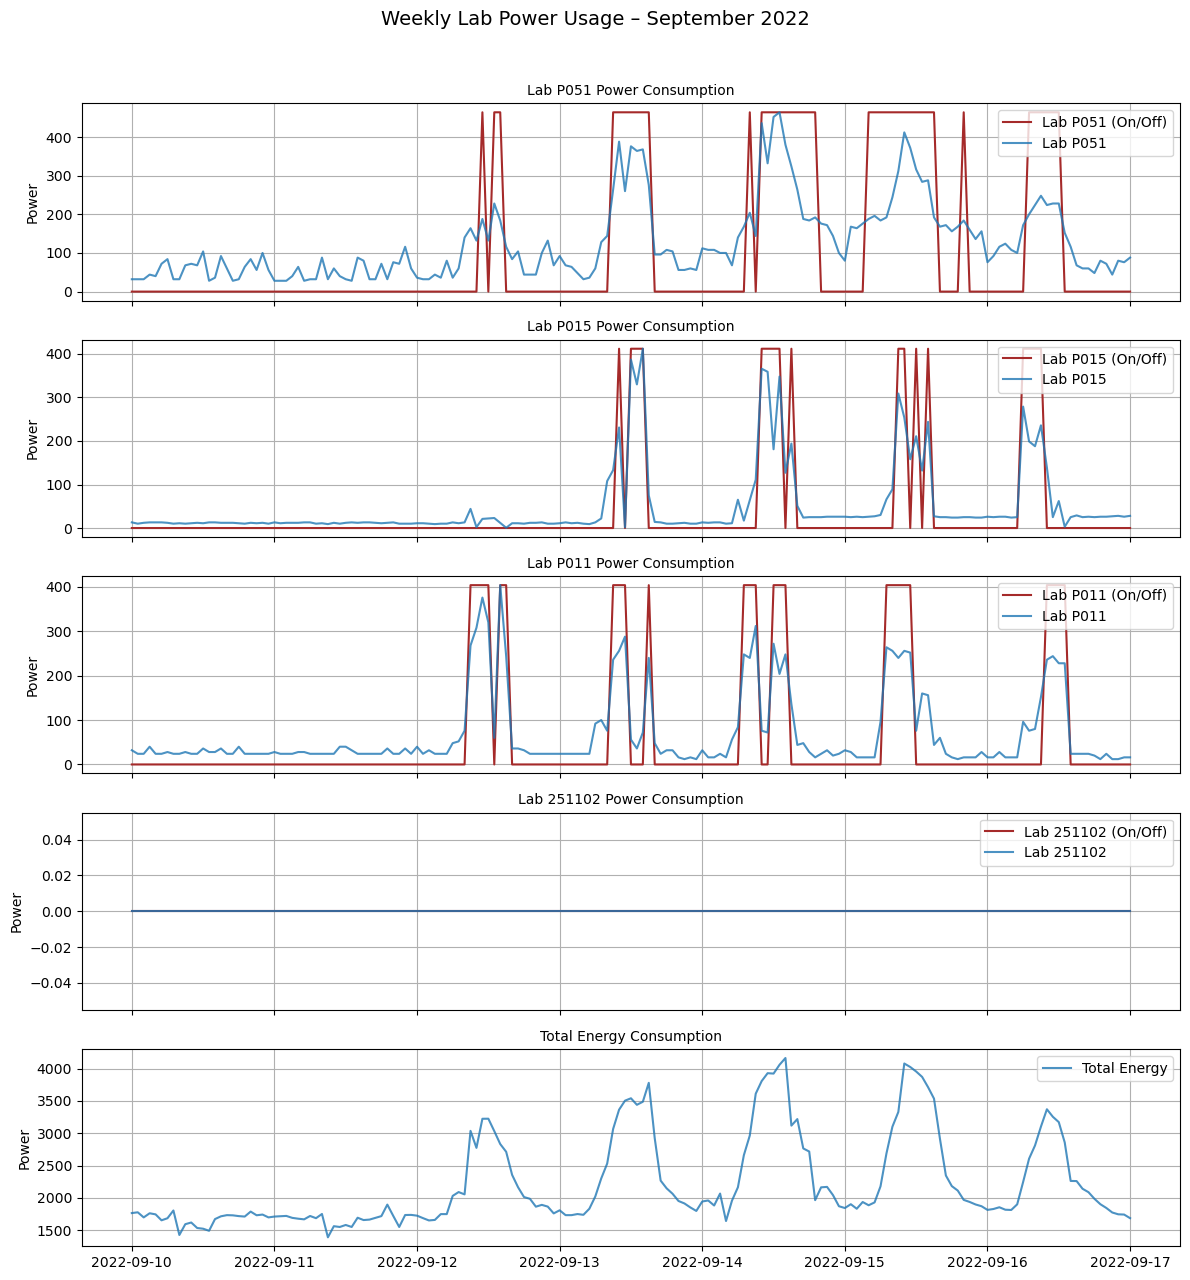

In [373]:
BINARY_THRESHOLD = 180

# Create a binary power column efficiently
def convert_power_to_binary(df, threshold=BINARY_THRESHOLD):
    df = df.copy()
    df['on_off'] = (df['power'] >= threshold).astype(int)
    return df

# Preprocess lab data: rename columns, compute binary
def preprocess_lab_data(lab_name, lab_df, threshold=BINARY_THRESHOLD):
    power_col = f"{lab_name}_power"
    binary_col = f"{lab_name}_binary"
    
    lab_df = lab_df.rename(columns={"power": power_col})
    lab_df[binary_col] = (lab_df[power_col] >= threshold).astype(int)
    
    return lab_df[[power_col, binary_col]]

# Prepare all lab data
laboratories_dict = {
    "lab_P051": lab_P051,
    "lab_P015": lab_P015,
    "lab_P011": lab_P011,
    "lab_251102": lab_251102,
    # Add more labs here
}

# Step 1: Create main energy dataframe
complete_lab_data = energy_data.rename(columns={"energy": "total_energy_consumption"}).copy()

# Step 2: Join each lab's processed data
for lab_name, lab_df in laboratories_dict.items():
    lab_processed = preprocess_lab_data(lab_name, lab_df)
    complete_lab_data = complete_lab_data.join(lab_processed, how='left')

# Step 3: Generate binary versions for plotting
lab_binaries = {
    name: convert_power_to_binary(df)
    for name, df in laboratories_dict.items()
}

# Step 4: Define plotting configuration
labs = [
    ("Lab P051", lab_P051, lab_binaries["lab_P051"], "Lab P051 Power Consumption"),
    ("Lab P015", lab_P015, lab_binaries["lab_P015"], "Lab P015 Power Consumption"),
    ("Lab P011", lab_P011, lab_binaries["lab_P011"], "Lab P011 Power Consumption"),
    ("Lab 251102", lab_251102, lab_binaries["lab_251102"], "Lab 251102 Power Consumption"),
    ("Total Energy", energy_data, None, "Total Energy Consumption")
]

# Step 5: Plot
fig, axes = plt.subplots(len(labs), 1, figsize=(12, 2.5 * len(labs)), sharex=True)
fig.subplots_adjust(top=0.95, bottom=0.05, hspace=0.35)

time_start = '2022-09-10 00:00:00'
time_end = '2022-09-17 00:00:00'

for ax, (label, original_df, binary_df, subtitle) in zip(axes, labs):
    original_segment = original_df.loc[time_start:time_end]

    if binary_df is not None:
        binary_segment = binary_df.loc[time_start:time_end]
        max_power = original_segment['power'].max()
        binary_scaled = binary_segment['on_off'] * max_power
        ax.plot(binary_scaled.index, binary_scaled, label=f"{label} (On/Off)", color='brown')

    if label == "Total Energy":
        ax.plot(original_segment.index, original_segment['energy'], label=label, alpha=0.8)
    else:
        ax.plot(original_segment.index, original_segment['power'], label=label, alpha=0.8)

    ax.set_title(subtitle, fontsize=10)
    ax.set_ylabel("Power")
    ax.grid(True)
    ax.legend(loc='upper right')
    ax.label_outer()

plt.suptitle('Weekly Lab Power Usage – September 2022', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [374]:
# Filter binary vectors from complete_lab_data
binary_vectors = complete_lab_data.filter(like='_binary')

# Combine all relevant DataFrames
data_frames = [
    energy_data,
    glob_irrad_in_diffuse_df,
    glob_irrad_total_disc_df,
    dew_point_df,
    enth_df,
    rel_hum_df,
    temp_df,
    binary_vectors
]

# Concatenate all DataFrames along columns axis and sort index
combined_data = pd.concat(data_frames, axis='columns').sort_index()


In [375]:
combined_data


,energy,glob_irrad_in_diffuse,glob_irrad_total_disc,dew_point,enth,rel_hum,temp,lab_P051_binary,lab_P015_binary,lab_P011_binary,lab_251102_binary
time,,,,,,,,,,,
2022-03-26 13:00:00,NaN,137.109728,661.895943,4.128571,34.430769,32.103774,21.378571,NaN,NaN,NaN,NaN
2022-03-26 14:00:00,1342.0,141.183676,577.268724,3.115385,33.660000,29.877628,21.461538,0.0,0.0,0.0,0.0
2022-03-26 15:00:00,1431.0,114.570251,424.230759,1.666667,NaN,28.074964,20.720000,0.0,0.0,0.0,0.0
2022-03-26 16:00:00,1454.0,86.464229,247.396151,0.909091,NaN,26.885974,20.650000,0.0,0.0,0.0,0.0
2022-03-26 17:00:00,1555.0,42.434159,90.084536,0.440000,30.100000,26.701900,20.142857,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-29 04:00:00,1508.0,6.975227,6.698552,6.266667,24.750000,78.980000,9.525000,0.0,0.0,0.0,0.0
2023-04-29 05:00:00,1502.0,52.642305,66.405693,6.966667,25.583333,80.333333,10.000000,0.0,0.0,0.0,0.0
2023-04-29 06:00:00,1539.0,130.152907,210.525441,9.308333,30.666667,81.000000,12.291667,0.0,0.0,0.0,0.0


In [376]:
combined_data = combined_data.drop(['glob_irrad_in_diffuse', 'glob_irrad_total_disc'], axis=1)


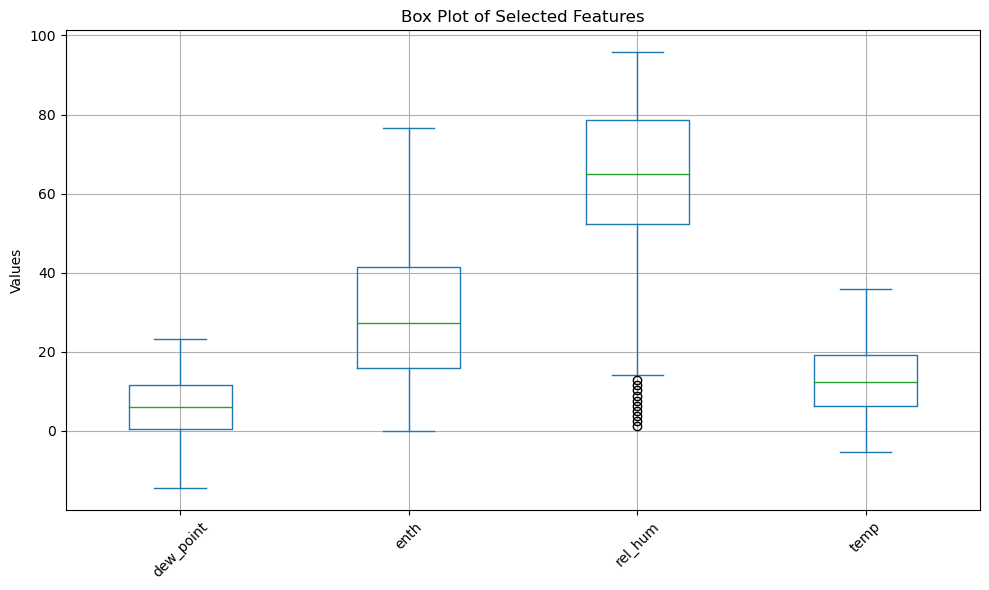

In [ ]:
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = [

    'dew_point',
    'enth',
    'rel_hum',
    'temp'
]

# Box plot
combined_data[columns_to_plot].plot(kind='box', figsize=(10, 6), grid=True)

plt.title("Box Plot of Selected Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
combined_data.describe()

,energy,dew_point,enth,rel_hum,temp,lab_P051_binary,lab_P015_binary,lab_P011_binary,lab_251102_binary
count,9571.000000,8978.000000,8622.000000,9572.000000,9086.000000,9571.000000,9571.000000,9571.000000,9571.000000
mean,2119.705255,6.027672,29.517972,64.797479,13.039443,0.218786,0.095915,0.091109,0.051092
std,784.039268,7.293471,16.189498,15.734704,8.214434,0.413445,0.294490,0.287778,0.220197
min,984.000000,-14.483333,0.000000,1.154169,-5.466667,0.000000,0.000000,0.000000,0.000000
25%,1609.000000,0.500000,15.818750,52.400000,6.200000,0.000000,0.000000,0.000000,0.000000
50%,1806.000000,6.141667,27.291667,64.904110,12.458333,0.000000,0.000000,0.000000,0.000000
75%,2475.000000,11.662500,41.400000,78.733333,19.179444,0.000000,0.000000,0.000000,0.000000
max,6572.000000,23.273333,76.678261,95.781795,35.864286,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Calculating IQR

IQR_rel_hum = 78.733333 - 52.400000
#printing

print("IQR for rel_hum is: ",IQR_rel_hum)

#Calculating Lower & Upper Extreme for rel_hum
LE_rh = 52.400000 - IQR_rel_hum * 1.5
UE_rh = 78.733333 + IQR_rel_hum * 1.5

#printing
print("Lower Extreme of IQR_rel_hum is: ",LE_rh)
print("Upper Extreme of IQR_rel_hum is: ",UE_rh)


IQR for rel_hum is:  26.333333000000003
Lower Extreme of IQR_rel_hum is:  12.900000499999997
Upper Extreme of IQR_rel_hum is:  118.2333325


In [ ]:
combined_data.shape

(9572, 9)

In [ ]:
# Checking Total Outliers for Lower Extreme of rel_hum
len(combined_data[combined_data.rel_hum<LE_rh])

10

In [ ]:
#Removing Outliers of rel_hum
df = combined_data
df1 = df[~(df.rel_hum<LE_rh)]
df1.shape

(9562, 9)

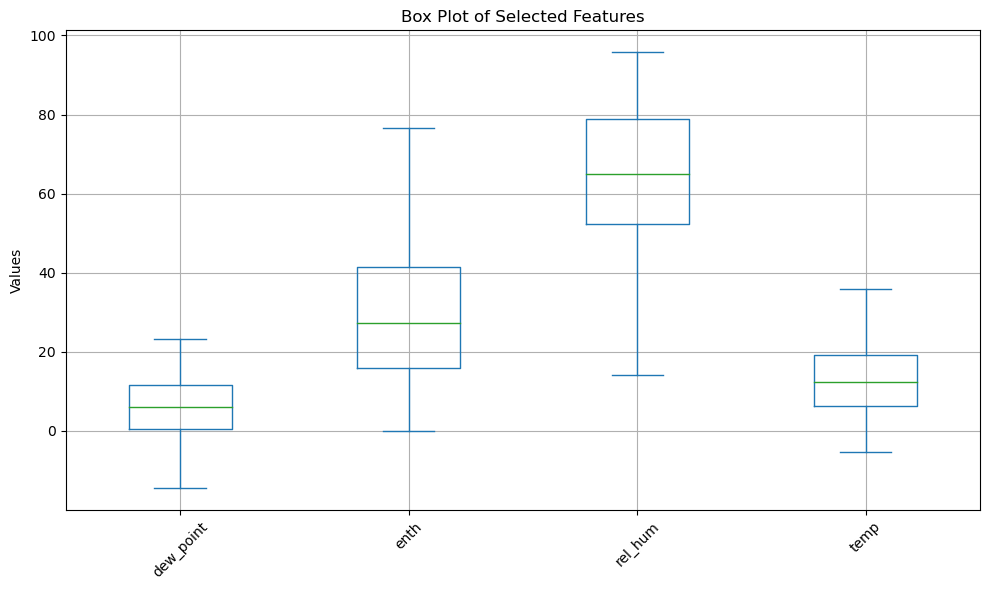

In [ ]:
import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = [
    'dew_point',
    'enth',
    'rel_hum',
    'temp'
]

# Box plot
df1[columns_to_plot].plot(kind='box', figsize=(10, 6), grid=True)

plt.title("Box Plot of Selected Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df1.isnull().sum()

energy                 1
dew_point            584
enth                 940
rel_hum                0
temp                 476
lab_P051_binary        1
lab_P015_binary        1
lab_P011_binary        1
lab_251102_binary      1
dtype: int64

In [ ]:
def get_is_schoolday(date_arg):
    '''
    arg: datetime object
    returns 1: if it is a school day
    returns 0: if date is either in the weekend, a public holiday, or during school break in Styria
    '''
    # Convert to date only (removes hour/minutes/seconds)
    date_arg = date_arg.date()
    
    # Classes at TU Graz
    classes = [
        ('2022-03-26', '2022-04-08'),
        ('2022-04-25', '2022-05-26'),
        ('2022-05-30', '2022-06-03'),
        ('2022-06-08', '2022-06-30'),
        ('2022-10-03', '2022-11-01'),
        ('2022-11-03', '2022-12-20'),
        ('2023-01-09', '2023-01-31'),
        ('2023-03-01', '2023-03-31'),
    ]

    # Convert date ranges to datetime.date objects
    class_periods = [(pd.Timestamp(start).date(), pd.Timestamp(end).date()) for start, end in classes]

    # Check if the day is a weekend
    if date_arg.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return 0

    # Check if the date is within school periods
    for start, end in class_periods:
        if start <= date_arg <= end:
            return 1
    
    return 0



In [ ]:
from datetime import datetime
# Sample dates to test
test_dates =[
    datetime(2022, 3, 28),  # Weekday, during class → expect 1
    datetime(2022, 4, 9),   # Saturday → expect 0
    datetime(2022, 4, 15),  # Good Friday (holiday) → expect 0
    datetime(2022, 5, 2),   # Weekday, during class → expect 1
    datetime(2022, 7, 1),   # Weekday, but not in class period → expect 0
    datetime(2023, 3, 15),  # Weekday, during class → expect 1
    datetime(2023, 12, 25), # Christmas (holiday) → expect 0
]

# Print results
for d in test_dates:
    print(f"{d.strftime('%Y-%m-%d')} → School Day: {get_is_schoolday(d)}")
    


2022-03-28 → School Day: 1
2022-04-09 → School Day: 0
2022-04-15 → School Day: 0
2022-05-02 → School Day: 1
2022-07-01 → School Day: 0
2023-03-15 → School Day: 1
2023-12-25 → School Day: 0


In [ ]:
df1['WorkDay'] = df1.index.map(get_is_schoolday)

C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\1243660600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['WorkDay'] = df1.index.map(get_is_schoolday)


In [ ]:
# Create time-based features
df1['day_of_week'] = df1.index.day_of_week
df1['month'] = df1.index.month
df1['year'] = df1.index.year
df1['hour'] = df1.index.hour
df1["day"] = df1.index.day
df1["day_of_year"] = df1.index.day_of_year



C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\3450851385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['day_of_week'] = df1.index.day_of_week
C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\3450851385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = df1.index.month
C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\3450851385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [ ]:



# Function for Cyclical Encoding
def cyclical_encoding(X, variable, max_value):
    X[f"{variable}_sin"] = np.sin(X[variable] * 2.0 * np.pi / max_value)
    X[f"{variable}_cos"] = np.cos(X[variable] * 2.0 * np.pi / max_value)
    return X

# Apply cyclical encoding
df1 = cyclical_encoding(df1, 'day_of_week', 7)  # Days of the week: 0-6
df1 = cyclical_encoding(df1, 'hour', 24)      # Hours: 0-23
df1 = cyclical_encoding(df1, 'month', 12)     # Months: 1-12

# Grouping based on WorkDays, Weekends, and Seasons
df_workday_jan = df1[(df1.index.month == 1) & (df1.WorkDay == 1)]
df_workday_jul = df1[(df1.index.month == 7) & (df1.WorkDay == 1)]

df_weekend_jan = df1[(df1.index.month == 1) & (df1.WorkDay == 0)]
df_weekend_jul = df1[(df1.index.month == 7) & (df1.WorkDay == 0)]

# Weekday groups by season
df_weekday_sum = df1[(df1.index.month.isin([6,7,8])) & (df1.WorkDay == 1)]
df_weekday_win = df1[(df1.index.month.isin([12,1,2])) & (df1.WorkDay == 1)]
df_weekday_spr = df1[(df1.index.month.isin([3,4,5])) & (df1.WorkDay == 1)]
df_weekday_aut = df1[(df1.index.month.isin([9,10,11])) & (df1.WorkDay == 1)]

# Weekend/Holiday groups by season
df_weekend_sum = df1[(df1.index.month.isin([6,7,8])) & (df1.WorkDay == 0)]
df_weekend_win = df1[(df1.index.month.isin([12,1,2])) & (df1.WorkDay == 0)]
df_weekend_spr = df1[(df1.index.month.isin([3,4,5])) & (df1.WorkDay == 0)]
df_weekend_aut = df1[(df1.index.month.isin([9,10,11])) & (df1.WorkDay == 0)]

# Seasonal grouping
df_summer = df1[df1.index.month.isin([6,7,8])]
df_winter = df1[df1.index.month.isin([12,1,2])]
df_spring = df1[df1.index.month.isin([3,4,5])]
df_autumn = df1[df1.index.month.isin([9,10,11])]


C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\488739812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{variable}_sin"] = np.sin(X[variable] * 2.0 * np.pi / max_value)
C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\488739812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{variable}_cos"] = np.cos(X[variable] * 2.0 * np.pi / max_value)
C:\Users\bcs\AppData\Local\Temp\ipykernel_11624\488739812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [399]:
df1.to_csv("../data/newdata.csv")